In [1]:
from openeye import oechem, oeomega
from rdkit import Chem, Geometry
import oenotebook as oenb

## OEBond Stereochemistry Details

In order to make bond stereochemistry work for either toolkit, it required knowing information about the atoms around the bond. I thought it would be instructive to show how this works before moving to the conversion between rdmol and oemols.

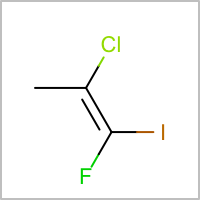

In [2]:
mol = oechem.OEMol()
oechem.OESmilesToMol(mol, 'F\\C(I)=C\\(Cl)C')
oenb.draw_mol(mol)

### Relative Stereochemistry

In both toolkits stereochemistry is specified based on relatively positions. 
In Chemistry, we usually think of stereochemistry based on the atoms with highest priority so we would say this bond 
is cis (or Z) because the iodine and chlorine are on the same side of the double bond. 
However we can also think of this relatively so the double bond is cis or trans depending on which atoms you are 
currently using as a reference. 

Therefore the double bond is 
* Trans with Cl and F as reference
* Cis with C and F as reference
* Cis with Cl and I as reference
* Trans with C and I as a reference

This point is illustrated with the example function below, which was only slightly adapted from the [OpenEye Stereochemistry Documentation Examples](https://docs.eyesopen.com/toolkits/python/oechemtk/stereochemistry.html).
The general conclusion from this is that you don't actually need to know the absolute stereochemistry of a bond, you just need two reference atoms and know what the stereochemistry is in that direction. 

In [3]:
def print_bond_stereo(oe_mol):
    """
    This function prints all pairs of atoms that could be used to specify bond stereochemistry
    OpenEye allows you to query for bond stereochemistry with any comination of neighboring atoms so
    there are a total of 4 combinations of atoms for every bond.
    """
    for bond in oe_mol.GetBonds():
        if bond.HasStereoSpecified(oechem.OEBondStereo_CisTrans):
            for atomB in bond.GetBgn().GetAtoms():
                if atomB == bond.GetEnd():
                    continue
                for atomE in bond.GetEnd().GetAtoms():
                    if atomE == bond.GetBgn():
                        continue
                    v = []
                    v.append(atomB)
                    v.append(atomE)
                    stereo = bond.GetStereo(v, oechem.OEBondStereo_CisTrans)
                    print("Atoms: %i (#%i)" %( atomB.GetIdx(), atomB.GetAtomicNum()), end=' ')
                    print("and %i (#%i)" % (atomE.GetIdx(), atomE.GetAtomicNum()), "are", end=" ")

                    if stereo == oechem.OEBondStereo_Cis:
                        print("cis")
                    elif stereo == oechem.OEBondStereo_Trans:
                        print("trans")

# show all atom combinations you could use to specify stereochemistry
print_bond_stereo(mol)

Atoms: 0 (#9) and 4 (#17) are trans
Atoms: 0 (#9) and 5 (#6) are cis
Atoms: 2 (#53) and 4 (#17) are cis
Atoms: 2 (#53) and 5 (#6) are trans


# RDMol to OEMol

The function below converts a molecule from RDMol to OEMol.
Currently this includes 

Atoms: 
* formal charge
* aromaticity
* atomic number
* chirality

Bonds:
* connecting atoms
* order
* aromaticity
* stereochemistry

**Not Included:**
* Coordinates
* Arbitrary data
    - both OpenEye and RDKit allow arbitrary data to be stored on atoms, bonds, and molecules. This function does nothing to make sure that information is extracted as it seemed outside the scope of this project.

In [8]:
def oemol_from_rdmol(rdmol):
    """
    Creates an openeye molecule object that is identical to the input rdkit molecule
    """
    # RDK automatically includes explicit hydrogens in its SMILES patterns
    print("Starting molecule: ", Chem.MolToSmiles(Chem.RemoveHs(rdmol))) 
    
    # openeye stores bond orders as integers regardless of aromaticity
    # in order to properly extract these, we need to have the "Kekulized" version of the rdkit mol
    kekul_mol = Chem.Mol(rdmol)
    Chem.Kekulize(kekul_mol, True)
    
    oemol = oechem.OEMol()
    map_atoms = dict() # {rd_idx: oe_atom}
    
    # setting chirality in openey requires using neighbor atoms
    # therefore we can't do it until after the atoms and bonds are all added
    chiral_atoms = dict() # {rd_idx: openeye chirality}
    for rda in rdmol.GetAtoms():
        rd_idx = rda.GetIdx()
        
        # create a new atom
        oe_a = oemol.NewAtom(rda.GetAtomicNum())
        map_atoms[rd_idx] = oe_a
        oe_a.SetFormalCharge(rda.GetFormalCharge())
        oe_a.SetAromatic(rda.GetIsAromatic())

        # If chiral, store the chirality to be set later
        tag = rda.GetChiralTag() 
        if tag == Chem.CHI_TETRAHEDRAL_CCW:
            chiral_atoms[rd_idx] = oechem.OECIPAtomStereo_R
        if tag == Chem.CHI_TETRAHEDRAL_CW:
            chiral_atoms[rd_idx] = oechem.OECIPAtomStereo_S

    # Similar to chirality, stereochemistry of bonds in OE is set relative to their neighbors
    stereo_bonds = list()
    # stereo_bonds stores tuples in the form (oe_bond, rd_idx1, rd_idx2, OE stereo specification)
    # where rd_idx1 and 2 are the atoms on the outside of the bond
    # i.e. Cl and F in the example above
    aro_bond = 0
    for rdb in rdmol.GetBonds():
        a1 = rdb.GetBeginAtomIdx()
        a2 = rdb.GetEndAtomIdx()
        
        # create a new bond
        newbond = oemol.NewBond(map_atoms[a1], map_atoms[a2])
        
        order = rdb.GetBondTypeAsDouble()
        if order == 1.5: 
            # get the bond order for this bond in the kekulized molecule
            order = kekul_mol.GetBondWithIdx(rdb.GetIdx()).GetBondTypeAsDouble()
            newbond.SetAromatic(True)
        else:
            newbond.SetAromatic(False)
        newbond.SetOrder(int(order))

        # determine if stereochemistry is needed
        tag = rdb.GetStereo()
        if tag == Chem.BondStereo.STEREOCIS or tag == Chem.BondStereo.STEREOZ:
            stereo_atoms = rdb.GetStereoAtoms()
            stereo_bonds.append((newbond, stereo_atoms[0], stereo_atoms[1], oechem.OEBondStereo_Cis))
            
            bond2 = rdmol.GetBondBetweenAtoms(stereo_atoms[0], a1)
            bond4 = rdmol.GetBondBetweenAtoms(stereo_atoms[1], a2)
            print(tag, bond2.GetBondDir(), bond4.GetBondDir())
        if tag == Chem.BondStereo.STEREOTRANS or tag == Chem.BondStereo.STEREOE:
            stereo_atoms = rdb.GetStereoAtoms()
            stereo_bonds.append((newbond, stereo_atoms[0], stereo_atoms[1], oechem.OEBondStereo_Trans))
            bond2 = rdmol.GetBondBetweenAtoms(stereo_atoms[0], a1)
            bond4 = rdmol.GetBondBetweenAtoms(stereo_atoms[1], a2)
            print(tag, bond2.GetBondDir(), bond4.GetBondDir())
            
    # Now that all of the atoms are connected we can set stereochemistry
    # starting with atom chirality
    for rd_idx, chirality in chiral_atoms.items():
        # chirality is set relative to neighbors, so we will get neighboring atoms
        # assign Right handed direction, check the cip stereochemistry
        # if the cip stereochemistry isn't correct then we'll set left and double check
        
        oea = map_atoms[rd_idx]
        neighs = [n for n in oea.GetAtoms()]
        # incase you look at the documentation oe has two options for handedness for example:
        # oechem.OEAtomStereo_Left == oechem.OEAtomStereo_LeftHanded
        oea.SetStereo(neighs, oechem.OEAtomStereo_Tetra, oechem.OEAtomStereo_Right)
        cip = oechem.OEPerceiveCIPStereo(oemol, oea)
        if cip != chirality:
            oea.SetStereo(neighs, oechem.OEAtomStereo_Tetra, oechem.OEAtomStereo_Left)
            new_cip = oechem.OEPerceiveCIPStereo(oemol, oea)
            if new_cip != chirality:
                # Note, I haven't seen this happen yet, but it shouldn't be a problem since there 
                # is only 2 directions for handedness and we're only running this for chiral atoms
                print("PANIC!")

    # Set stereochemistry using the reference atoms extracted above
    for oeb, idx1, idx2, oestereo in stereo_bonds:
        oeb.SetStereo([map_atoms[idx1], map_atoms[idx2]], oechem.OEBondStereo_CisTrans, oestereo)

    # If the rdmol has a conformer, add its coordinates to the oemol
    # Note, this currently only adds the first conformer, it will need to be adjusted if the
    # you wanted to convert multiple sets of coordinates
    if rdmol.GetConformers():
        print("found an rdmol conformer")
        conf = rdmol.GetConformer()
        for rd_idx, oeatom in map_atoms.items():
            coords = conf.GetAtomPosition(rd_idx)
            oemol.SetCoords(oeatom, oechem.OEFloatArray(coords))
        
    # If RDMol has a title save it
    if rdmol.HasProp("_Name"):
        oemol.SetTitle(rdmol.GetProp("_Name"))
        
    # Clean Up phase
    # The only feature of a molecule that wasn't perceived above seemed to be ring connectivity, better to run it
    # here then for someone to inquire about ring sizes and get 0 when it shouldn't be
    oechem.OEFindRingAtomsAndBonds(oemol)
    
    print('Final Molecule: ', oechem.OEMolToSmiles(oemol))
    return oemol

# RDMol from OEMol

The function below converts a molecule from RDMol to OEMol. 
This example was built from Shuzhe Wang's
[example for openforcefiel](https://github.com/openforcefield/openforcefield/blob/swang/openforcefield/utils/utils.py#L512).
I skipped the coordinates part as it seemed outside the scope of my current needs, but you should know you can set coordinates by individual atom with 
```
oemol.SetCoords( oeatom, oechem.OEFloatArray( (x, y, z) ) )
```

Currently the method below includes:

Atoms: 
* formal charge
* aromaticity
* atomic number
* chirality

Bonds:
* connecting atoms
* order
* aromaticity
* stereochemistry

**Not Included:**
* Coordinates
* Arbitrary data
    - both OpenEye and RDKit allow arbitrary data to be stored on atoms, bonds, and molecules. This function does nothing to make sure that information is extracted as it seemed outside the scope of this project.

### More Notes on Bond Stereochemistry 

Initially I tried setting stereochemistry with the `Bond.SetStereo` function which wasn't working. 
A [Source Forge](https://sourceforge.net/p/rdkit/mailman/message/19111378/) post from 2008 (a decade old?!) said that the `SetStereo` should not be accessed from python, a.k.a doesn't work. 
It was NOT clear from documentation why that would be the case and there seemed to be more recent python examples on GitHub that do use this function. 
However, following the suggestion in that [Source Forge](https://sourceforge.net/p/rdkit/mailman/message/19111378/) 
post to set stereochemistry using the neighboring bond directions did work. 

This is actually fairly convenient as OpenEye also works best when using relative positions to set the stereochemistry. 

The nomenclature/API point around these settings was a bit unintuitive to me. 
They use the API points `Chem.BondDir.ENDUPRIGHT` and `Chem.BondDir.ENDDOWNRIGHT`.
I thought it was directionally refering to where the bonds were, meaning trans bonds would be opposite and cis bonds would be the same words. 
However, it actually refers to the `"/"` and `"\"` in SMILES strings, that is `ENDUPRIGHT` is `"/"` and `ENDDOWNRIGHT` is `"\"`. 
Therefore, a cis bond would have opposite slashs as / then \ ( or in this API up then down).
Where trans bonds use / then / (up then up).

In [9]:
def rdmol_from_oemol(oemol):
    """
    Creates an openeye molecule object that is identical to the input rdkit molecule
    """
    print("Starting molecule: ", oechem.OEMolToSmiles(oemol))

    # start function
    rdmol = Chem.RWMol()

    # RDKit keeps bond order as a type instead using these values, I don't really understand 7, 
    # I took them from Shuzhe's example linked above
    _bondtypes = {1: Chem.BondType.SINGLE,
                  1.5: Chem.BondType.AROMATIC,
                  2: Chem.BondType.DOUBLE,
                  3: Chem.BondType.TRIPLE,
                  4: Chem.BondType.QUADRUPLE,
                  5: Chem.BondType.QUINTUPLE,
                  6: Chem.BondType.HEXTUPLE,
                  7: Chem.BondType.ONEANDAHALF,}

    # atom map lets you find atoms again
    map_atoms = dict() # {oe_idx: rd_idx}
    for oea in oemol.GetAtoms():
        oe_idx = oea.GetIdx()
        rda = Chem.Atom(oea.GetAtomicNum())
        rda.SetFormalCharge(oea.GetFormalCharge())
        rda.SetIsAromatic(oea.IsAromatic())

        # unlike OE, RDK lets you set chirality directly
        cip = oechem.OEPerceiveCIPStereo(oemol, oea)
        if cip == oechem.OECIPAtomStereo_S:
            rda.SetChiralTag(Chem.CHI_TETRAHEDRAL_CW)
        if cip == oechem.OECIPAtomStereo_R:
            rda.SetChiralTag(Chem.CHI_TETRAHEDRAL_CCW)

        map_atoms[oe_idx] = rdmol.AddAtom(rda)

    # As discussed above, setting bond stereochemistry requires neighboring bonds 
    # so we will store that information by atom index in this list 
    stereo_bonds = list()
    # stereo_bonds will have tuples with the form (rda1, rda2, rda3, rda4, is_cis)
    # where rda[n] is an atom index for a double bond of form 1-2=3-4 
    # and is_cis is a Boolean is True then onds 1-2 and 3-4 are cis to each other

    aro_bond = 0
    for oeb in oemol.GetBonds():
        # get neighboring rd atoms
        rd_a1 = map_atoms[oeb.GetBgnIdx()]
        rd_a2 = map_atoms[oeb.GetEndIdx()]

        # AddBond returns the total number of bonds, so addbond and then get it
        rdmol.AddBond(rd_a1, rd_a2)
        rdbond = rdmol.GetBondBetweenAtoms(rd_a1, rd_a2)

        # Assign bond type, which is based on order unless it is aromatic
        order = oeb.GetOrder()
        if oeb.IsAromatic():
            rdbond.SetBondType(_bondtypes[1.5])
            rdbond.SetIsAromatic(True)
        else:
            rdbond.SetBondType(_bondtypes[order])
            rdbond.SetIsAromatic(False)

        # If the bond has specified stereo add the required information to stereo_bonds
        if oeb.HasStereoSpecified(oechem.OEBondStereo_CisTrans):
            # OpenEye determined stereo based on neighboring atoms so get two outside atoms
            n1 = [n for n in oeb.GetBgn().GetAtoms() if n != oeb.GetEnd()][0]
            n2 = [n for n in oeb.GetEnd().GetAtoms() if n != oeb.GetBgn()][0]

            rd_n1 = map_atoms[n1.GetIdx()]
            rd_n2 = map_atoms[n2.GetIdx()]
    
            stereo = oeb.GetStereo([n1,n2], oechem.OEBondStereo_CisTrans)
            if stereo == oechem.OEBondStereo_Cis:
                print('cis')
                stereo_bonds.append((rd_n1, rd_a1, rd_a2, rd_n2, True))
            elif stereo == oechem.OEBondStereo_Trans:
                print('trans')
                stereo_bonds.append((rd_n1, rd_a1, rd_a2, rd_n2, False))  
    
    # add bond stereochemistry:
    for (rda1, rda2, rda3, rda4, is_cis) in stereo_bonds:
        # get neighbor bonds
        bond1 = rdmol.GetBondBetweenAtoms(rda1, rda2)
        bond2 = rdmol.GetBondBetweenAtoms(rda3, rda4)
        
        # Since this is relative, the first bond always goes up
        # as explained above these names come from SMILES slashes so UP/UP is Trans and Up/Down is cis
        bond1.SetBondDir(Chem.BondDir.ENDUPRIGHT)
        if is_cis:
            bond2.SetBondDir(Chem.BondDir.ENDDOWNRIGHT)
        else:
            bond2.SetBondDir(Chem.BondDir.ENDUPRIGHT)
    
    # if oemol has coordinates (The dimension is non-zero)
    # add those coordinates to the rdmol
    if oechem.OEGetDimensionFromCoords(oemol) > 0:
        print("oemol has 3D coords")
        conformer = Chem.Conformer()
        oecoords = oemol.GetCoords()
        for oe_idx, rd_idx in map_atoms.items():
            (x,y,z) = oecoords[oe_idx]
            conformer.SetAtomPosition(rd_idx, Geometry.Point3D(x,y,z))
        rdmol.AddConformer(conformer)    
    
    # Save the molecule title
    rdmol.SetProp("_Name", oemol.GetTitle())
    
    # Cleanup the rdmol
    # Note I copied UpdatePropertyCache and GetSSSR from Shuzhe's code to convert oemol to rdmol here:
    rdmol.UpdatePropertyCache(strict=False)
    Chem.GetSSSR(rdmol)
    # I added AssignStereochemistry which takes the directions of the bond set 
    # and assigns the stereochemistry tags on the double bonds
    Chem.AssignStereochemistry(rdmol, force=False) 
    
    print("Final Molecule: ", Chem.MolToSmiles(Chem.RemoveHs(rdmol), isomericSmiles=True))
    return rdmol.GetMol()

# Check performance

Start by making a list of SMILES for example molecules:

In [10]:
smiles_list = ['C/C(=C(\\F)/I)/Cl', 'C/C(=C(/F)\\I)/Cl', 'F[C@H](Cl)\\C=C/C', 'F[C@H](Cl)\\C=C\\C', 
               'c1ccccc1', 'C1=CNC=C1']

### Round Trip Starting with OEMol

In [11]:
for smiles in smiles_list:
    oemol = oechem.OEMol()
    if not oechem.OESmilesToMol(oemol, smiles):
        print("couldn't process SMILES ", smiles, end='\n\n')
        continue
    oechem.OEAddExplicitHydrogens(oemol)
    print("oe: %s" % (oechem.OEMolToSmiles(oemol)), end=' ')
    rdmol = Chem.MolFromSmiles(smiles)
    if rdmol is None:
        print("couldn't process ", smiles, end='\n\n')
        continue
    rdmol = Chem.AddHs(rdmol)
    
    print("rd: %s" % (Chem.MolToSmiles(Chem.RemoveHs(rdmol), isomericSmiles=True)))

    print('-'*80)
    print("Round Trip From OEMol")
    print('-'*80)
    rdmol2 = rdmol_from_oemol(oemol)
    new_oemol = oemol_from_rdmol(rdmol2)
    
    print('-'*80)
    print("Round Trip From RDMol")
    print('-'*80)
    oemol2 = oemol_from_rdmol(rdmol)
    new_rdmol = rdmol_from_oemol(oemol2)    
    print('\n\n\n')

oe: C/C(=C(\F)/I)/Cl rd: C/C(Cl)=C(\F)I
--------------------------------------------------------------------------------
Round Trip From OEMol
--------------------------------------------------------------------------------
Starting molecule:  C/C(=C(\F)/I)/Cl
cis
Final Molecule:  C/C(Cl)=C(\F)I
Starting molecule:  C/C(Cl)=C(\F)I
STEREOZ NONE NONE
Final Molecule:  C/C(=C(\F)/I)/Cl
--------------------------------------------------------------------------------
Round Trip From RDMol
--------------------------------------------------------------------------------
Starting molecule:  C/C(Cl)=C(\F)I
STEREOZ ENDUPRIGHT ENDUPRIGHT
Final Molecule:  C/C(=C(\F)/I)/Cl
Starting molecule:  C/C(=C(\F)/I)/Cl
cis
Final Molecule:  C/C(Cl)=C(\F)I




oe: C/C(=C(/F)\I)/Cl rd: C/C(Cl)=C(/F)I
--------------------------------------------------------------------------------
Round Trip From OEMol
--------------------------------------------------------------------------------
Starting molecule:  C/C(=C(/F)\I

# What you need to store

Just for completeness, I thought I would add a list of what information I think you must keep in order to retain the chemical identity of a molecule:

Atoms:

* atomic number
* formal charge
* aromaticity (may not be as necessary here as it is for bonds)
* R/S/None Chirality

Bonds:

* connected atoms
* order (integer)
    * if double - cis/trans/none based on reference atoms one bond away
* aromaticity

# Try with 3D Coordinates

Start with using oemage to create 3D coordinates on an OEMol and then go to and from RDK

In [13]:
omega = oeomega.OEOmega()
omega.SetMaxConfs(1)
omega.SetIncludeInput(False)

In [15]:
for smiles in smiles_list:
    oemol = oechem.OEMol()
    if not oechem.OESmilesToMol(oemol, smiles):
        print("couldn't process SMILES ", smiles, end='\n\n')
        continue
    oechem.OEAddExplicitHydrogens(oemol)
    if not omega(oemol):
        print("couldn't use omega on %s" % smiles, end='\n\n')
        continue
    
    print('-'*80)
    print("Round Trip From OEMol")
    print('-'*80)
    rdmol2 = rdmol_from_oemol(oemol)
    new_oemol = oemol_from_rdmol(rdmol2)
    print('\n\n')

--------------------------------------------------------------------------------
Round Trip From OEMol
--------------------------------------------------------------------------------
Starting molecule:  C/C(=C(\F)/I)/Cl
cis
oemol has 3D coords
Final Molecule:  C/C(Cl)=C(/F)I
Starting molecule:  C/C(Cl)=C(/F)I
STEREOE NONE NONE
found an rdmol conformer
Final Molecule:  C/C(=C(/F)\I)/Cl



--------------------------------------------------------------------------------
Round Trip From OEMol
--------------------------------------------------------------------------------
Starting molecule:  C/C(=C(/F)\I)/Cl
trans
oemol has 3D coords
Final Molecule:  C/C(Cl)=C(\F)I
Starting molecule:  C/C(Cl)=C(\F)I
STEREOZ NONE NONE
found an rdmol conformer
Final Molecule:  C/C(=C(\F)/I)/Cl



--------------------------------------------------------------------------------
Round Trip From OEMol
--------------------------------------------------------------------------------
Starting molecule:  C/C=C\[C@H